**Execution time ~1'**

In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import scrublet as scr
import os

import sys
sys.path.append('../../')
from scCustomFunctions import *

from parameters import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
a = scp.read("data/raw.h5ad")

In [3]:
recompute = False

# Basic QC measures

We perform a common quality control wiith the following measures:
 
 1. Number of UMI counts per cell
 2. Number of expressed genes per cell
 3. Number of expressing cells per gene
 4. Mitocondrial fraction
 
It is of relevance to notice that the data extracted from Pijuan and Sala already contains some strict cutoffs over the data:

 1. nCounts > 5000
 2. mtFraction < 2.37%

In [4]:
mtGenesPos = np.array([i for i,j in enumerate(a.var["Gene"]) if "mt-" in j])
mtGenesNames = np.array([j for i,j in enumerate(a.var["Gene"]) if "mt-" in j])

In [5]:
a.obs["nCounts"] = np.array(np.sum(a.X,axis=1))[:,0]
a.obs["nGenes"] = np.array(np.sum(a.X>0,axis=1))[:,0]
a.obs["mtFraction"] = np.array(np.sum(a.X[:,mtGenesPos],axis=1))[:,0]/a.obs["nCounts"]
a.var["nCells"] = np.array(np.sum(a.X>0,axis=0))[0,:]

## UMI counts per cell

The UMI counts had already a high lower cutoff. We do not increase the constrain as it seems to fall in the basin of the bimodality between the removed lower UMI count (<5000) and the proper count distribution.

We do not set any upper bound, in the same way of their analysis. If high count cells are doublets, very probably they will be detected in by the doublet deconvolution procedure we will perform afterwards.

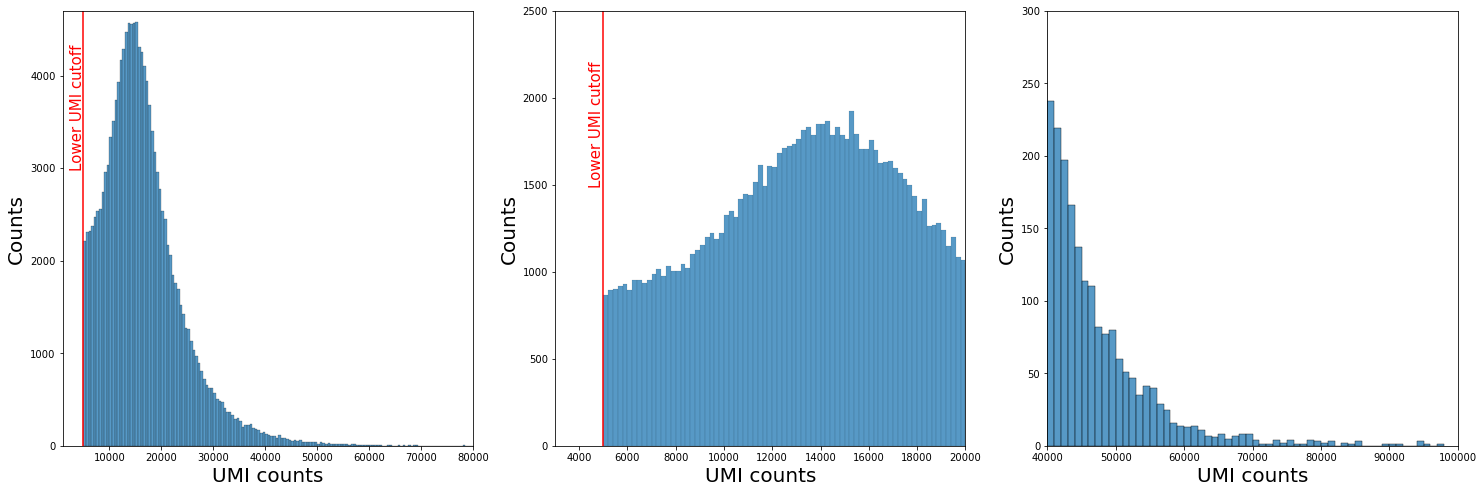

In [6]:
fig,ax = plt.subplots(1,3,figsize=[25,8])

#nCounts
i0 = 0; i1 = None;
sb.histplot(data=a.obs,x="nCounts",ax=ax[i0],binwidth=500);
ax[i0].axis([1000,80000,0,4700])
ax[i0].vlines(MIN_COUNTS,0,5000,color="r")
ax[i0].text(MIN_COUNTS-2600,3000,"Lower UMI cutoff",color="red",fontsize=15,rotation="vertical")
#ax[i0,i1].vlines(maxCounts,0,5000,color="r")
#ax[i0,i1].text(maxCounts+600,3500,"Upper UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("UMI counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 1; i1 = 1;
sb.histplot(data=a.obs,x="nCounts",ax=ax[i0],binwidth=200);
ax[i0].axis([3000,20000,0,2500])
ax[i0].vlines(MIN_COUNTS,0,5000,color="r")
ax[i0].text(MIN_COUNTS-600,1500,"Lower UMI cutoff",color="red",fontsize=15,rotation="vertical")
#ax[i0,i1].vlines(maxCounts,0,5000,color="r")
#ax[i0,i1].text(maxCounts+600,3500,"Upper UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("UMI counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 2; i1 = 2;
sb.histplot(data=a.obs,x="nCounts",ax=ax[i0],binwidth=1000);
ax[i0].axis([40000,100000,0,300])
#ax[i0,i1].vlines(minCounts,0,5000,color="r")
#ax[i0,i1].text(minCounts-600,1500,"Lower UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].vlines(MAX_COUNTS,0,5000,color="r")
#ax[i0,i1].text(maxCounts+600,3500,"Upper UMI cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("UMI counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

fig.savefig("Plots/1_QC_UMI_counts.png",bbox_inches="tight",transparent=True)
fig.show()

## Gene counts per cell

The number of gene counts show a clear bimodality. This is perfectly normal since the dataset has a very extense variety of cell types with different genetic patterns. We do not constraint at all the distribution at all, as in the analysis of Pijuan and set very loose bounds.


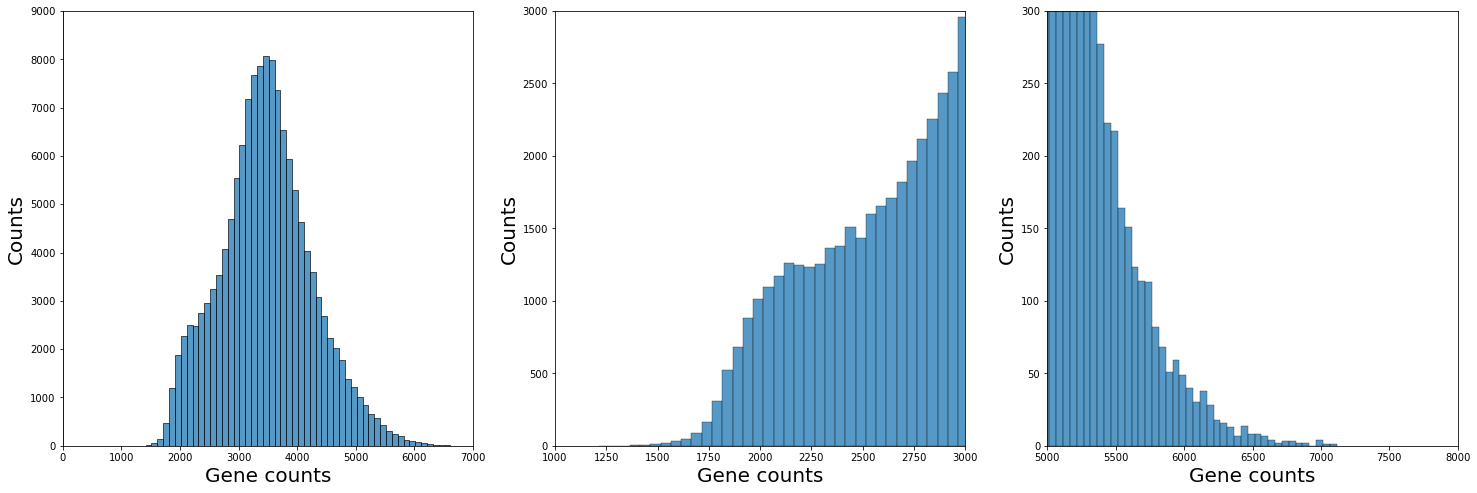

In [7]:
fig,ax = plt.subplots(1,3,figsize=[25,8])

#nGenes
i0 = 0; i1 = 0;
sb.histplot(data=a.obs,x="nGenes",ax=ax[i0],binwidth=100);
ax[i0].axis([0,7000,0,9000])
ax[i0].vlines(MIN_GENES,0,10000,color="r")
#ax[i0].text(MIN_GENES-300,1500,"Lower nGenes cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Gene counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 1; i1 = 1;
sb.histplot(data=a.obs,x="nGenes",ax=ax[i0],binwidth=50);
ax[i0].axis([1000,3000,0,3000])
ax[i0].vlines(MIN_GENES,0,4000,color="r")
#ax[i0].text(MIN_GENES-100,1500,"Lower nGenes cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Gene counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

i0 = 2; i1 = 2;
sb.histplot(data=a.obs,x="nGenes",ax=ax[i0],binwidth=50);
ax[i0].axis([5000,8000,0,300])
ax[i0].vlines(MAX_GENES,0,5000,color="r")
#ax[i0].text(MAX_GENES+100,100,"Higher nGenes cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Gene counts",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

fig.savefig("Plots/1_QC_Gene_counts.png",bbox_inches="tight",transparent=True)
fig.show()

## Mitochondrial fraction

The dataset has already a predefined upper bound, which will represent dead or dying cells. According to Pijuan's article, after a extremely convoluted process involving clustering the data in a very sloppy way they concluded that they should also remove all cells with a mitochondrial fraction below 0.005.

I consider this process to be very weird and suspicious and simply chose a lower bound according to the bidomal distribution of the mt fraction. This subset if considered to be due to stripped cells, which exploded and only genes from the nuclei are present mostly. 

In [8]:
print("Removed mitochondrial genes: ", mtGenesNames)

Removed mitochondrial genes:  ['mt-Nd1' 'mt-Nd2' 'mt-Co1' 'mt-Co2' 'mt-Atp8' 'mt-Atp6' 'mt-Co3' 'mt-Nd3'
 'mt-Nd4l' 'mt-Nd4' 'mt-Nd5' 'mt-Nd6' 'mt-Cytb']


Although it is clear that there is a subset of cells that show a extremelly low expression of mitochondrial genes, which will be an indicator of stripped cells, in the original work, this fraction is never removed from the system.

In order to stay as close as possible to the results of the original work, **we will not remove the stipped cells at this point**.

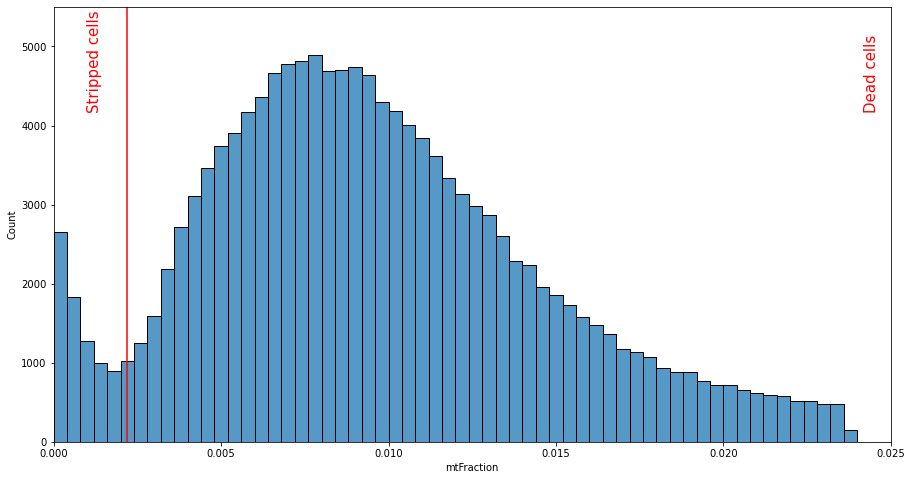

In [9]:
fig,ax = plt.subplots(1,1,figsize=[15,8])

#metFraction
i0 = 3; i1 = 0;
sb.histplot(data=a.obs,x="mtFraction",ax=ax,binwidth=0.0004);
ax.axis([0,0.025,0,5500])
ax.vlines(MIN_MT_FRACTION,0,6000,color="r")
ax.text(0.001,4200,"Stripped cells",color="red",fontsize=15,rotation="vertical")
ax.vlines(MAX_MT_FRACTION,0,6000,color="r")
ax.text(0.0242,4200,"Dead cells",color="red",fontsize=15,rotation="vertical")

fig.savefig("Plots/1_QC_mt_fraction.png",bbox_inches="tight",transparent=True)
fig.show()

## Scatter plot of the above limits

From the scatter plot it looks like there is a bimodality. This may happen because a certain set of cells have a different gene expression diversity as other cells. We discuss that in a [section below](#Bimodality). 

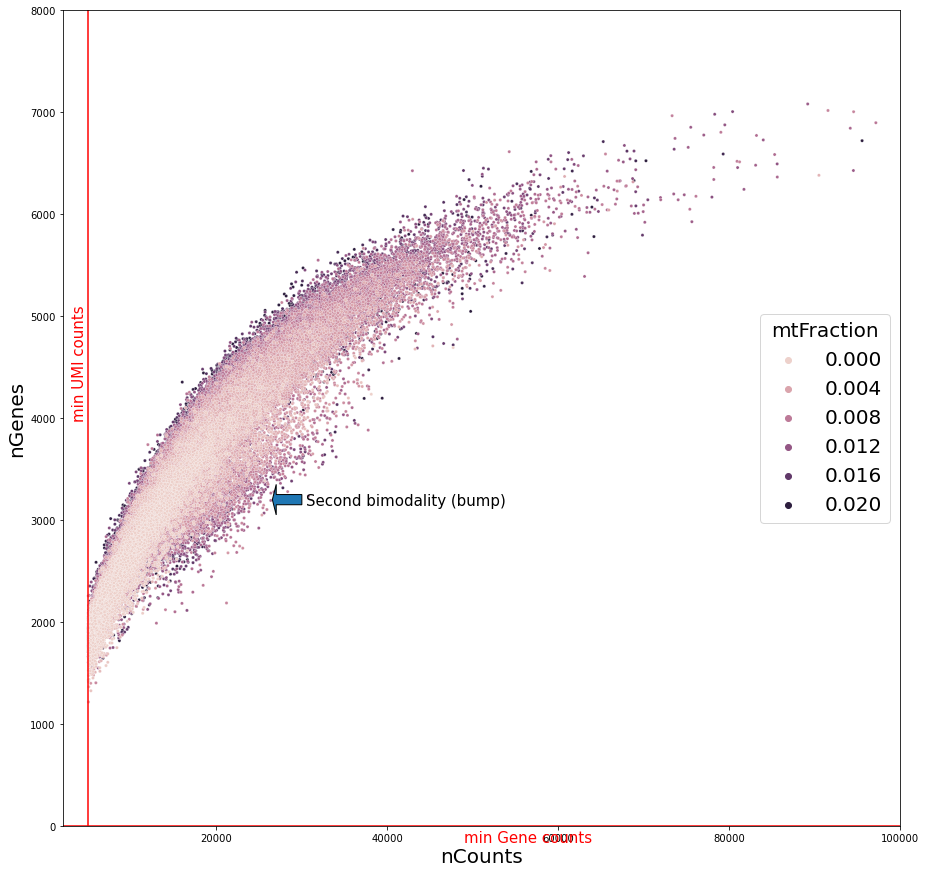

In [10]:
fig,ax = plt.subplots(1,1,figsize=[15,15])

i0 = 0
data = a.obs.copy()
data.sort_values("mtFraction",inplace=True,ascending=False)
sb.scatterplot(x="nCounts",y="nGenes",hue="mtFraction",data=data,hue_norm=(0,0.02),ax=ax,s=10)
axis = [2000,100000,0,8000]
ax.legend(frameon=True,loc="center right",fontsize=20,title="mtFraction",title_fontsize=20)
ax.axis(axis)
ax.vlines(MAX_COUNTS,axis[2],axis[3])
#ax.text(maxCounts,5000,"min UMI count",rotation="vertical")
ax.vlines(MIN_COUNTS,axis[2],axis[3],color="r")
ax.text(MIN_COUNTS-(axis[1]-axis[0])*0.02,(axis[3]-axis[2])/2,"min UMI counts",color="r",rotation="vertical",fontsize=15)
#ax.hlines(MAX_GENES,axis[0],axis[1],color="r")
#ax.text((axis[1]-axis[0])/2,MAX_GENES+(axis[3]-axis[2])*0.01,"max Gene counts",color="r",rotation="horizontal",fontsize=15)
ax.hlines(MIN_GENES,axis[0],axis[1],color="r")
ax.text((axis[1]-axis[0])/2,MIN_GENES-(axis[3]-axis[2])*0.02,"min Gene counts",color="r",rotation="horizontal",fontsize=15)
ax.set_xlabel("nCounts",fontsize=20)
ax.set_ylabel("nGenes",fontsize=20)
ax.arrow(30000,3200,-3000,0,width=100)
ax.text(30500,3150,"Second bimodality (bump)",fontsize=15)

fig.savefig("Plots/1_QC_UMI_Genes_scatter.png",bbox_inches="tight",transparent=True)
fig.show()

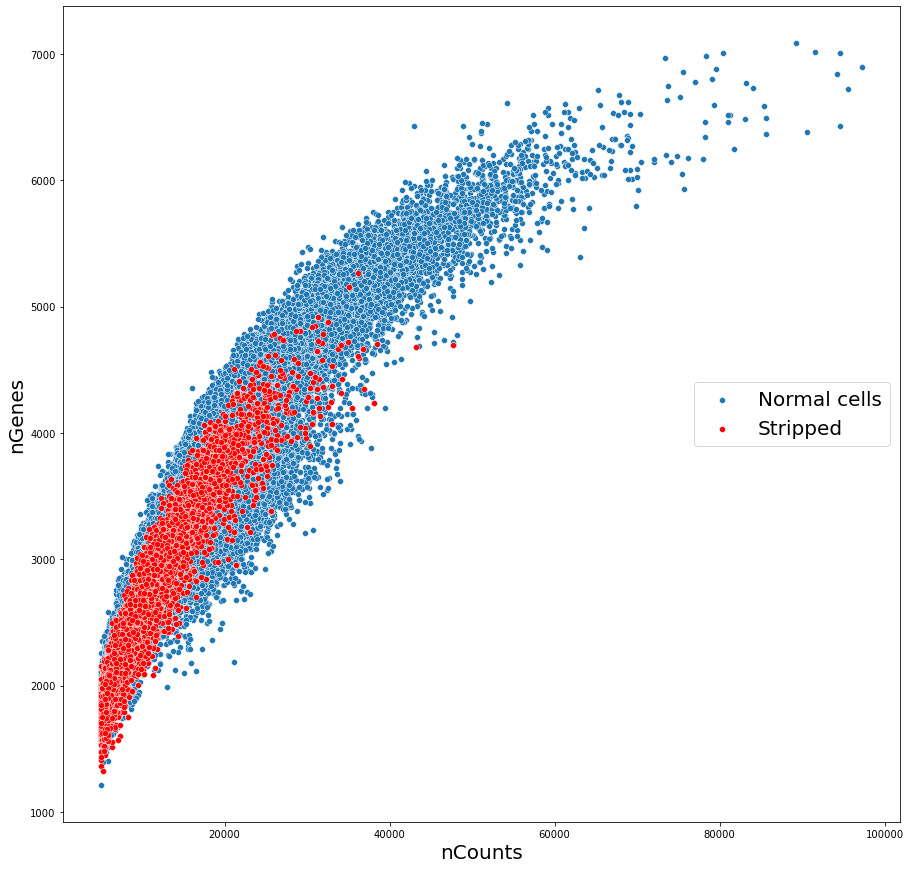

In [11]:
fig,ax = plt.subplots(1,1,figsize=[15,15])

i0 = 1
sb.scatterplot(x="nCounts",y="nGenes",data=a.obs,ax=ax)
sb.scatterplot(x="nCounts",y="nGenes",color="r",data=a.obs[a.obs["mtFraction"]<MIN_MT_FRACTION],ax=ax)
ax.legend(["Normal cells","Stripped"],frameon=True,loc="center right",fontsize=20)
ax.set_xlabel("nCounts",fontsize=20)
ax.set_ylabel("nGenes",fontsize=20)

fig.savefig("Plots/1_QC_UMI_Genes_stripped.png",bbox_inches="tight",transparent=True)
fig.show()

## Expressing cells per gene

Since there may be the case that there are very small populations of cells during developmental stages, we will consider a very loose cutoff of the expressing cells and we will remove only those genes that are not expressed at all in the dataset. This is a repetition of the analysis of Pijuan.

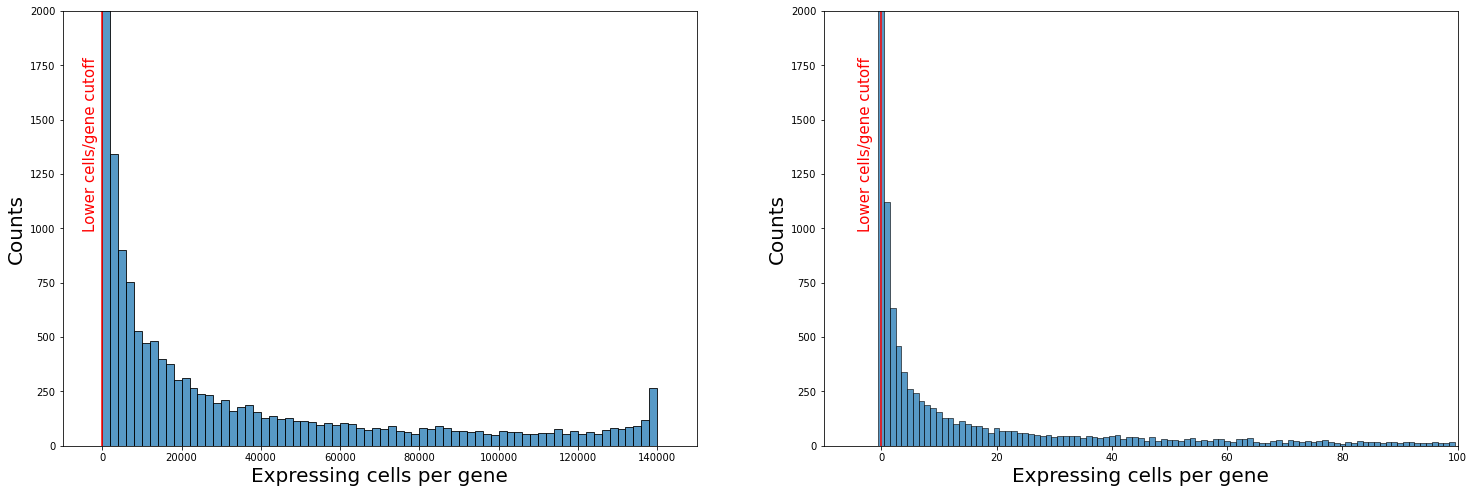

In [12]:
fig,ax = plt.subplots(1,2,figsize=[25,8])

#nCells
i0 = 0;
sb.histplot(data=a.var,x="nCells",ax=ax[i0],binwidth=2000);
ax[i0].axis([-10000,150000,0,2000])
ax[i0].vlines(MIN_GENES,0,5000,color="r")
ax[i0].text(-5000,1000,"Lower cells/gene cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Expressing cells per gene",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

#nCells
i0 = 1;
sb.histplot(data=a.var,x="nCells",ax=ax[i0],bins=np.arange(-.5,100.5,1));
ax[i0].axis([-10,100,0,2000])
ax[i0].vlines(MIN_GENES,0,5000,color="r")
ax[i0].text(-4,1000,"Lower cells/gene cutoff",color="red",fontsize=15,rotation="vertical")
ax[i0].set_xlabel("Expressing cells per gene",fontsize=20)
ax[i0].set_ylabel("Counts",fontsize=20)

fig.savefig("Plots/1_QC_Cell_counts.png",bbox_inches="tight",transparent=True)
fig.show()

## Plots by samples

We do a quality check over the different samples of the dataset.

From their preprocessing, they already eliminated one sample (11) because showed an anomalous number of cells. But we keep it for sake of consistency with the preprocessing performed in the original paper.

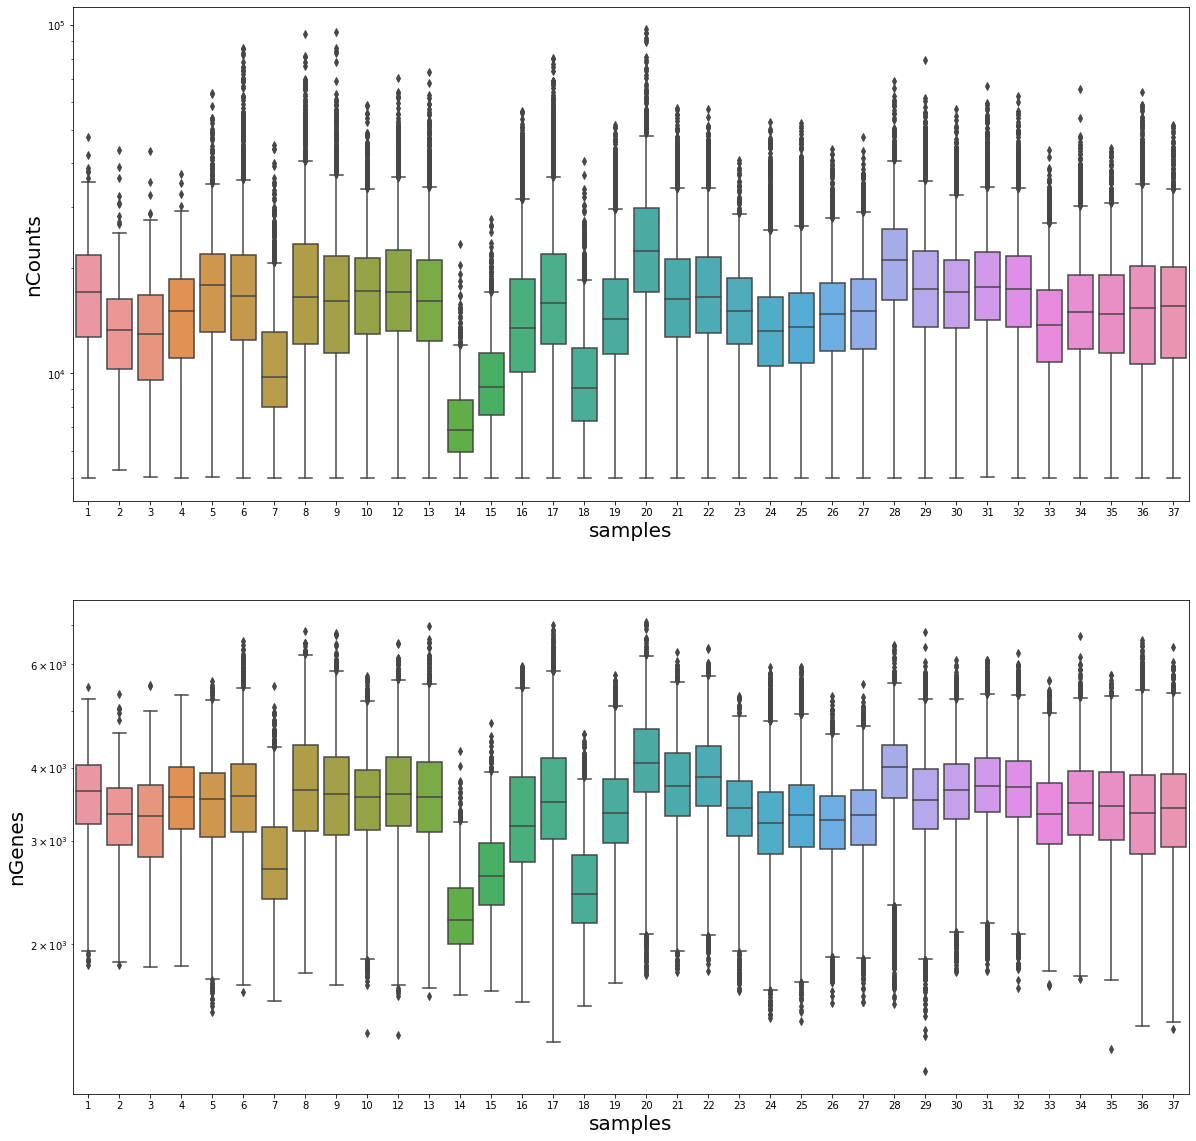

In [13]:
fig,ax = plt.subplots(2,1,figsize=[20,20])

sb.boxplot(y="nCounts",x="sample",data=a.obs,ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("samples",fontsize=20)
ax[0].set_ylabel("nCounts",fontsize=20)

sb.boxplot(y="nGenes",x="sample",data=a.obs,ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_xlabel("samples",fontsize=20)
ax[1].set_ylabel("nGenes",fontsize=20)

fig.savefig("Plots/1_QC_UMI_Genes_sample.png",bbox_inches="tight",transparent=True)
fig.show()

## Plots by stages

When plotting against the stages, there does not seem to be bias on the expression and count levels.

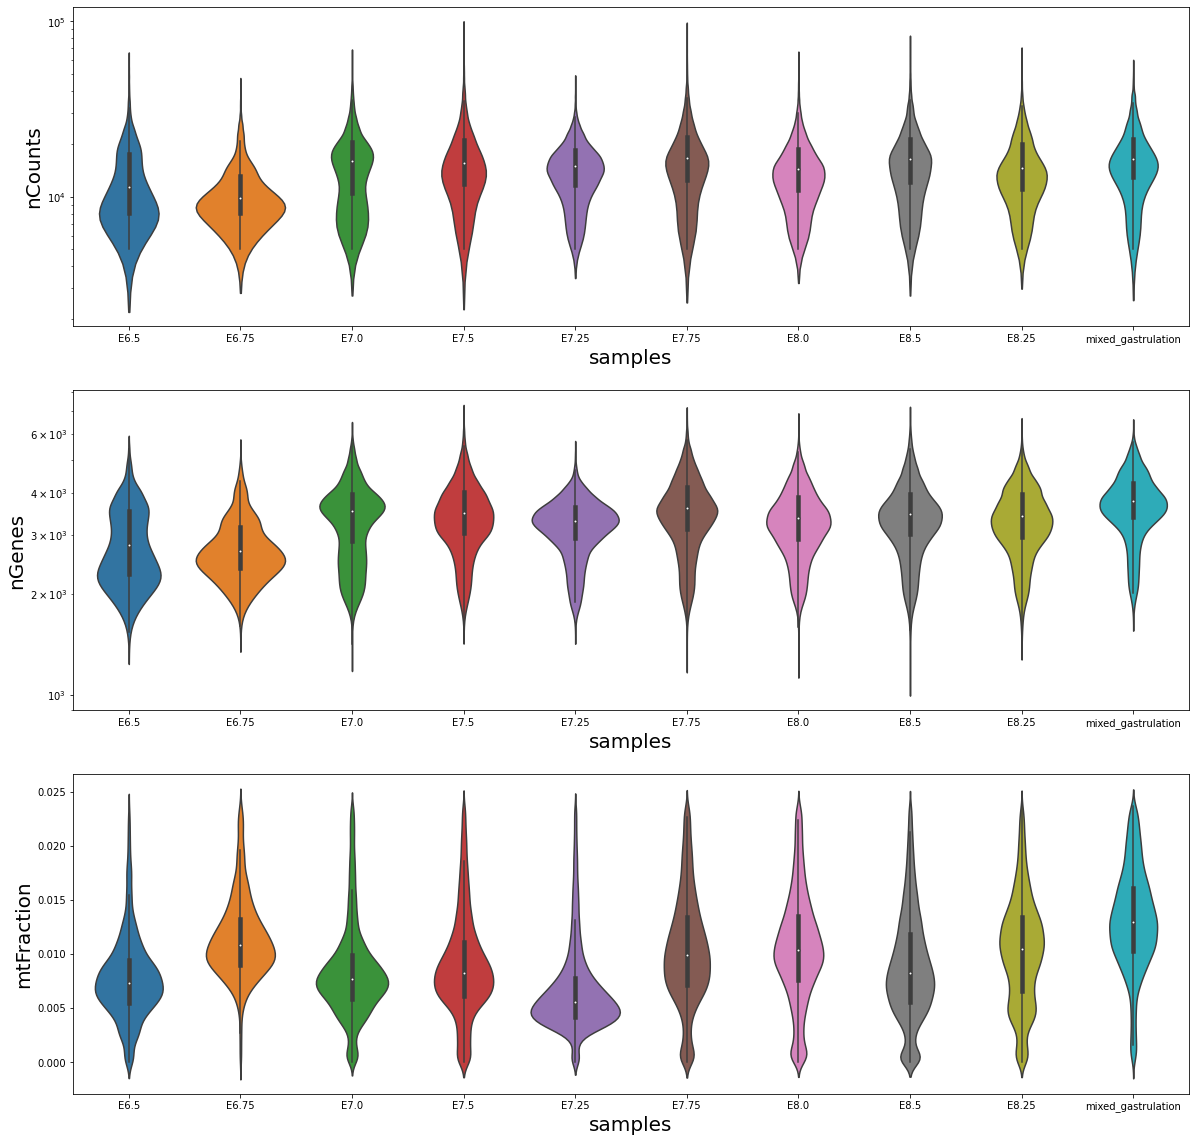

In [14]:
fig,ax = plt.subplots(3,1,figsize=[20,20])

sb.violinplot(y="nCounts",x="stage",data=a.obs,ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("samples",fontsize=20)
ax[0].set_ylabel("nCounts",fontsize=20)

sb.violinplot(y="nGenes",x="stage",data=a.obs,ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_xlabel("samples",fontsize=20)
ax[1].set_ylabel("nGenes",fontsize=20)

sb.violinplot(y="mtFraction",x="stage",data=a.obs,ax=ax[2])
ax[2].set_xlabel("samples",fontsize=20)
ax[2].set_ylabel("mtFraction",fontsize=20)

fig.savefig("Plots/1_QC_UMI_Genes_stage.png",bbox_inches="tight",transparent=True)
fig.show()

## Scatter plot bimodality 

As in Pijuan, we look at the gene Hbb-bh1, which is an indicator of blod cell lines. As it can be seen, the second bump in the scatter plot comes from cells expressing the blod cell line indicator and start appearing from the later stages of the development. 

Blod cells show a lower diversity of genes, which is represented in the plots by the second modality at a lower gene expression. This confirms that we are not runing into technical artifacts with the data.

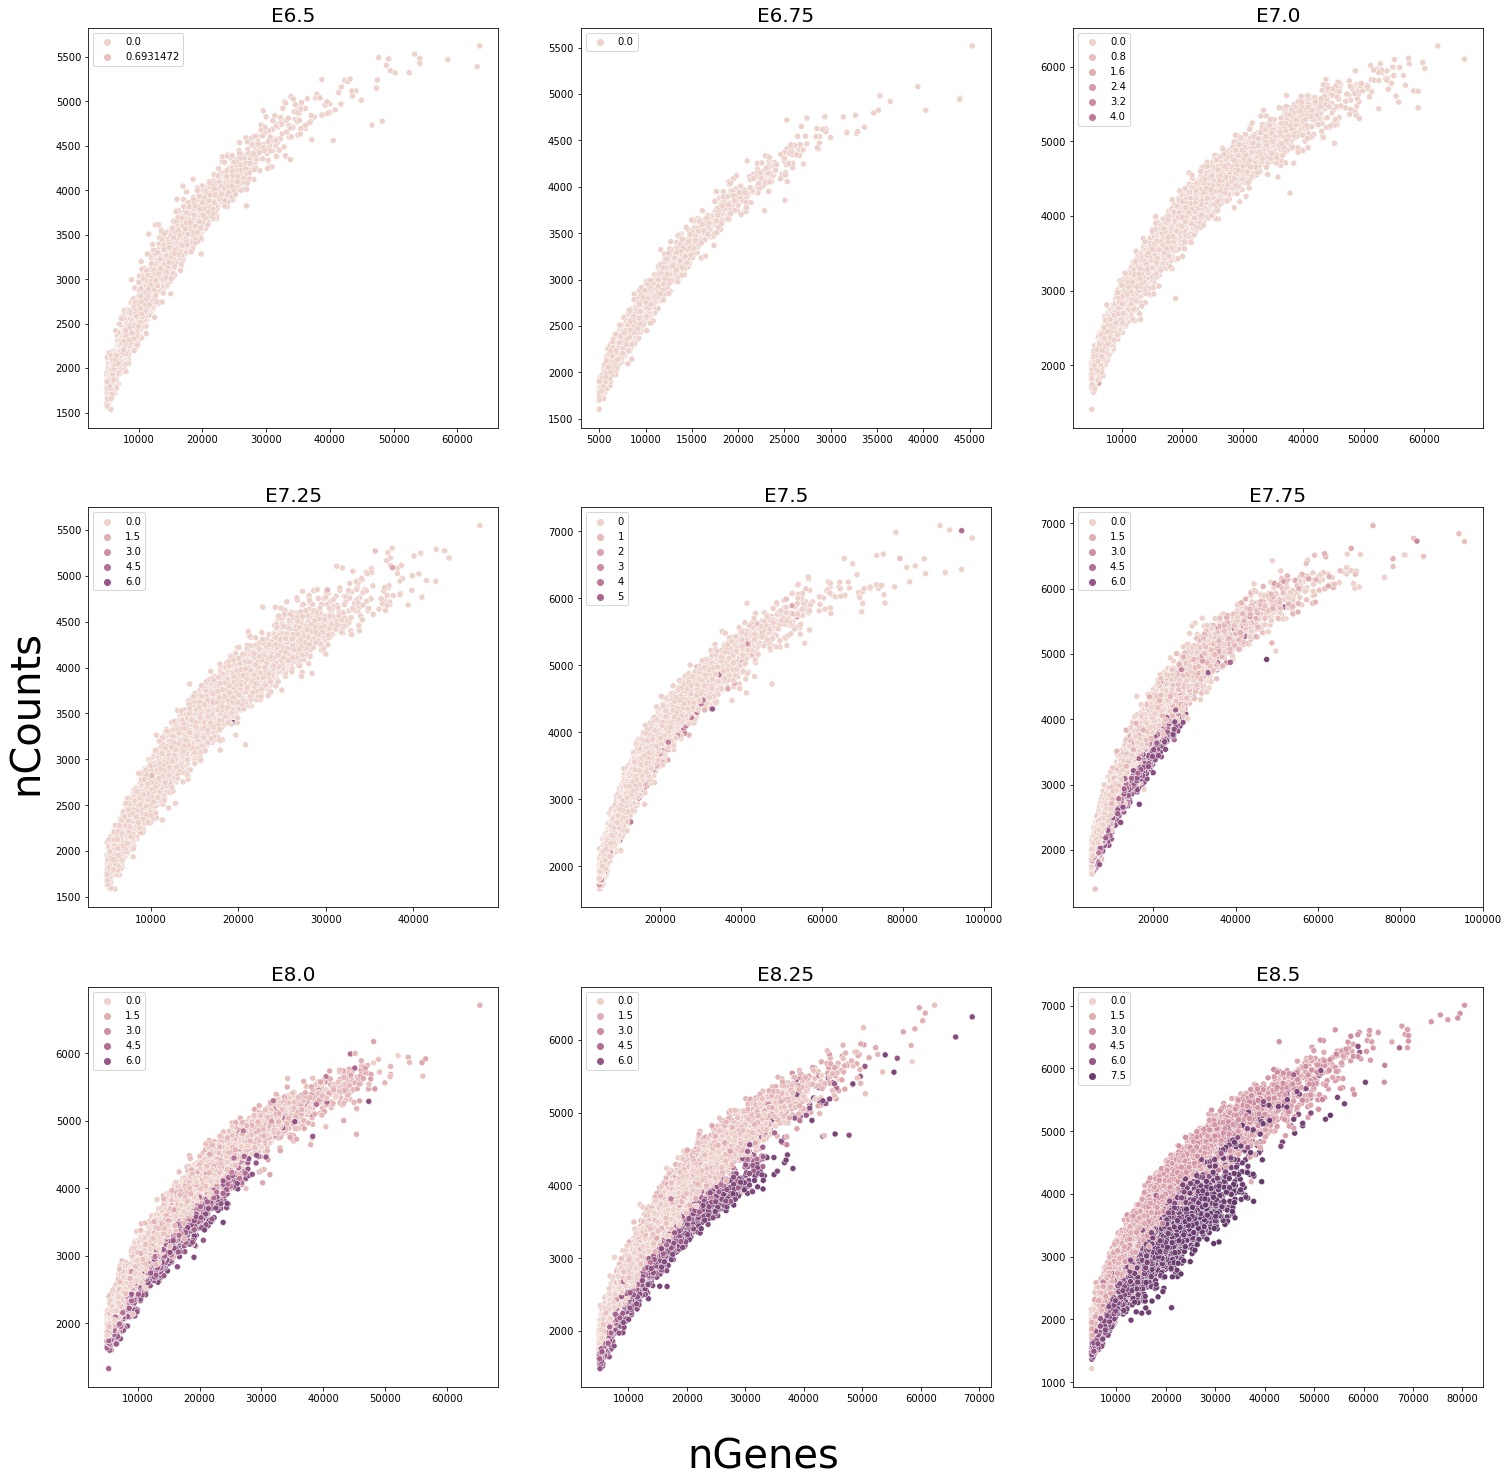

In [15]:
samp = np.sort(a.obs["stage"].values.unique())

fig,ax=plt.subplots(3,3,figsize=[25,25])
m = np.meshgrid(range(3),range(3))
hue = np.log(np.array(a[:,a.var["Gene"]=="Hbb-bh1"].X.todense()).reshape(-1)+1)
for i,j in zip(m[0].reshape(9),m[1].reshape(9)):
    k = 3*i+j
    l = a.obs["stage"]==samp[k]
    sb.scatterplot(x="nCounts",y="nGenes",hue=hue[l],hue_norm=(0,10),data=a.obs[l],ax=ax[i,j])
    ax[i,j].set_xlabel("")
    ax[i,j].set_ylabel("")
    ax[i,j].set_title(str(samp[k]),fontsize=20)#,loc='lower right')
    
fig.text(0.5, 0.08, 'nGenes', ha='center', fontsize=40)
fig.text(0.08, 0.5, 'nCounts', va='center', rotation='vertical', fontsize=40)

fig.savefig("Plots/1_QC_Second_bimodality.png",bbox_inches="tight",transparent=True)
fig.show()

# Doublets and refinement

In this stage we will remove all the cells that have high likelihood of being doublets.

Moreover, since the doublet scoring process is stochastic and prone to leave outliers, we further remove cells that have a high number of neighbors being doublets.

## Compute doublet scores

In [16]:
if recompute:
    a.obs["scrublet_doublet_score"] = 0
    a.obs["scrublet_doublet"] = False
    os.makedirs("./data/doublets",exist_ok=True)
    for stage in a.obs["stage"].unique():

        #Extract stage
        b = a[a.obs["stage"]==stage,:].copy()

        #Feature selection: HVGs
        scp.pp.normalize_total(b,target_sum=a.obs.loc[:,"nCounts"].mean())
        scp.pp.log1p(b) #Logarithmize data
        scp.pp.highly_variable_genes(b,flavor=HVG_METHOD) #Seurat flavour of obtaining HVGs

        #Steps for making a fine graining Louvain in which to share information among nearby cells
        data = pd.DataFrame(index = b.obs.index)
        #Dimension reduction: PCA
        scp.pp.pca(b,n_comps=N_PCS,use_highly_variable=USE_HVGs)
        #Batch correct: Harmony
        b.obs["sample"] = b.obs["sample"].astype("str")
        scp.external.pp.harmony_integrate(b,key="sample")
        #Neighbours
        scp.pp.neighbors(b,use_rep="X_pca_harmony",metric=METRIC,n_pcs=N_PCS,knn=N_NEIGBOURS)
        #UMAP
        scp.tl.umap(b)
        data["X1"] = b.obsm["X_umap"][:,0]
        data["X2"] = b.obsm["X_umap"][:,1]
        data.to_csv("data/doublets/QC_doublet_UMAP_"+stage+".csv")

        #Make doublet scores
        b.X = np.expm1(b.X) #Return to not logmirized data
        for i in b.obs["sample"].unique():
            # Generate samples
            b1 = b[b.obs["sample"]==i].copy()
            #b1.X = b1.obsm["raw"].copy() #Use raw data
            b2 = scp.external.pp.scrublet_simulate_doublets(b1,sim_doublet_ratio=2,random_seed=1)

            #Normalize (Normalize again because simulate doublets just adds pairs of cells)
            scp.pp.normalize_total(b1,target_sum=np.mean(a.obs["nCounts"]))
            scp.pp.normalize_total(b2,target_sum=np.mean(a.obs["nCounts"]))

            #Reduce to highly variable genes for the projection and 
            remove = np.array(np.sum(b1.X,axis=0))[0]!=0 * b1.var["highly_variable"]
            b1 = b1[:,remove].copy()
            b2 = b2[:,remove].copy()

            #Make scrublet scores in the log transformed space
            scp.external.pp.scrublet(b1,b2,
                                    knn_dist_metric = METRIC,
                                    n_prin_comps = N_PCS,
                                    log_transform=True,
                                    verbose=True)

            np.save("./data/doublets/simulation_doublet_score_sample_"+i+".npy",b1.uns['scrublet']['doublet_scores_sim'])

            a.obs.loc[b1.obs.index,"scrublet_doublet_score"] = b1.obs["doublet_score"]
            a.obs.loc[b1.obs.index,"scrublet_doublet"] = b1.obs["predicted_doublet"]

    a.write("data/raw.h5ad")

## Simulated doublet statistics

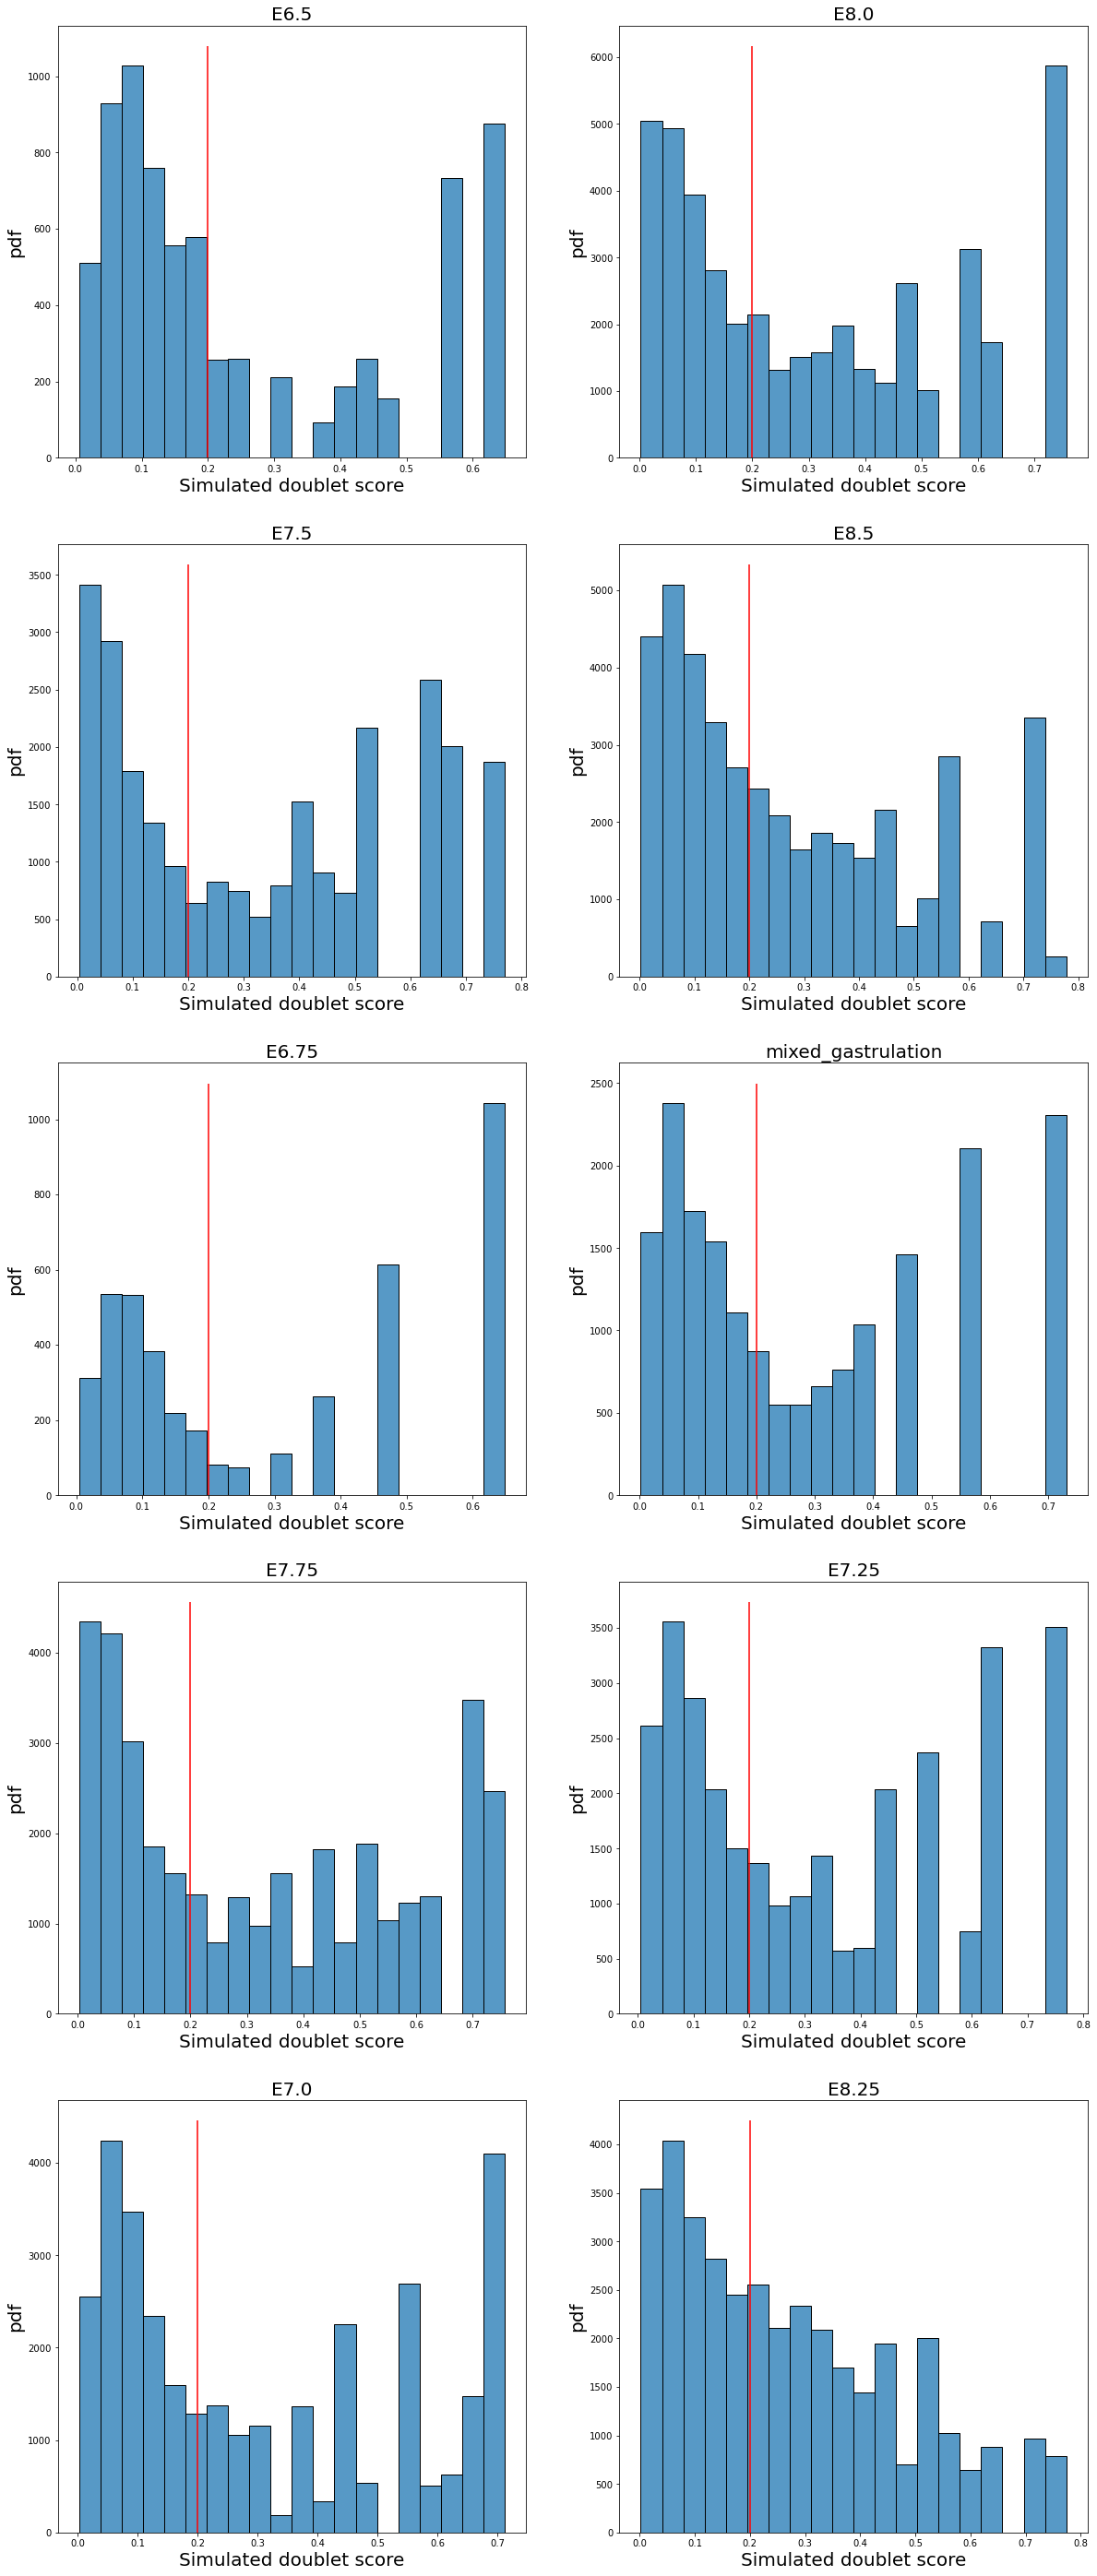

In [17]:
fig,ax = plt.subplots(5,2,figsize=[20,50])
for i,stage in enumerate(a.obs["stage"].unique()):
    
    posx = i%5
    posy = i//5

    bObs = a.obs.loc[a.obs["stage"]==stage,:]
    
    #Make selection again for ploting purposes
    select_doublets = (bObs["nCounts"]>MAX_N_COUNTS) | (bObs["scrublet_doublet_score"]>DOUBLET_SCORE_MAX_THRESHOLD)
    select_doublets = select_doublets.values
    select_stripped = (bObs["mtFraction"]<MIN_MT_FRACTION)
    select_stripped = select_stripped.values
    aux_select_stripped = (bObs["mtFraction"]<MIN_MT_FRACTION) | (bObs["nCounts"]>MAX_N_COUNTS)
    aux_select_stripped = aux_select_stripped.values
        
    # Plot simulated doublet distributions
    
    v = []
    for j in bObs["sample"].unique():
        l = np.load("data/doublets/simulation_doublet_score_sample_"+str(j)+".npy")
        v = np.append(v,l)
        
    sb.histplot(v,bins=20,ax=ax[posx,posy])
    ax[posx,posy].vlines(DOUBLET_SCORE_MAX_THRESHOLD,0,ax[posx,posy].get_ylim()[1],color="red")
    ax[posx,posy].set_title(stage,fontsize=20)
    ax[posx,posy].set_xlabel("Simulated doublet score",fontsize=20)
    ax[posx,posy].set_ylabel("pdf",fontsize=20)
    
    
fig.savefig("./Plots/1_QC_Control_simulated_doublets.png",bbox_inches="tight",transparent=True)

In [18]:
a.obs.loc[:,"imputed"] = (a.obs.loc[:,"mtFraction"] < MIN_MT_FRACTION) + (a.obs.loc[:,"scrublet_doublet_score"] > DOUBLET_SCORE_MAX_THRESHOLD)

## Compute probability of imputed neighborhood

In [21]:
if recompute:
    for stage in a.obs["stage"].unique():

        #Extract stage
        b = a[a.obs["stage"]==stage,:].copy()

        #Feature selection: HVGs
        scp.pp.normalize_total(b,target_sum=a.obs.loc[:,"nCounts"].mean())
        scp.pp.log1p(b) #Logarithmize data
        scp.pp.highly_variable_genes(b,flavor=HVG_METHOD) #Seurat flavour of obtaining HVGs

        #Steps for making a fine graining Louvain in which to share information among nearby cells
        data = pd.DataFrame(index = b.obs.index)
        #Dimension reduction: PCA
        scp.pp.pca(b,n_comps=N_PCS,use_highly_variable=USE_HVGs)
        #Batch correct: Harmony
        b.obs["sample"] = b.obs["sample"].astype("str")
        scp.external.pp.harmony_integrate(b,key="sample")
        #Neighbours
        scp.pp.neighbors(b,use_rep="X_pca_harmony",metric=METRIC,n_pcs=N_PCS,knn=N_NEIGBOURS)
        
        m  = pd.DataFrame(b.obs.loc[:,"imputed"][b.uns["neighbors"]["distances"].nonzero()[1]])
        m["b"] = b.uns["neighbors"]["distances"].nonzero()[0]
        m = m.groupby("b").mean()
        m["neighbors_doublets"] = m["imputed"]

        a.obs.loc[b.obs.index,"neighbors_imputed"] = m["neighbors_doublets"].values

    a.write("data/raw.h5ad")

2022-03-04 19:11:54,829 - harmonypy - INFO - Iteration 1 of 10
2022-03-04 19:11:55,283 - harmonypy - INFO - Iteration 2 of 10
2022-03-04 19:11:55,718 - harmonypy - INFO - Iteration 3 of 10
2022-03-04 19:11:56,142 - harmonypy - INFO - Iteration 4 of 10
2022-03-04 19:11:56,575 - harmonypy - INFO - Iteration 5 of 10
2022-03-04 19:11:56,876 - harmonypy - INFO - Iteration 6 of 10
2022-03-04 19:11:57,291 - harmonypy - INFO - Iteration 7 of 10
2022-03-04 19:11:57,520 - harmonypy - INFO - Iteration 8 of 10
2022-03-04 19:11:57,705 - harmonypy - INFO - Converged after 8 iterations
2022-03-04 19:12:00.787730: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 19:12:00.787745: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-04 19:12:12,983 - harmonyp

## Imputed UMAP plots

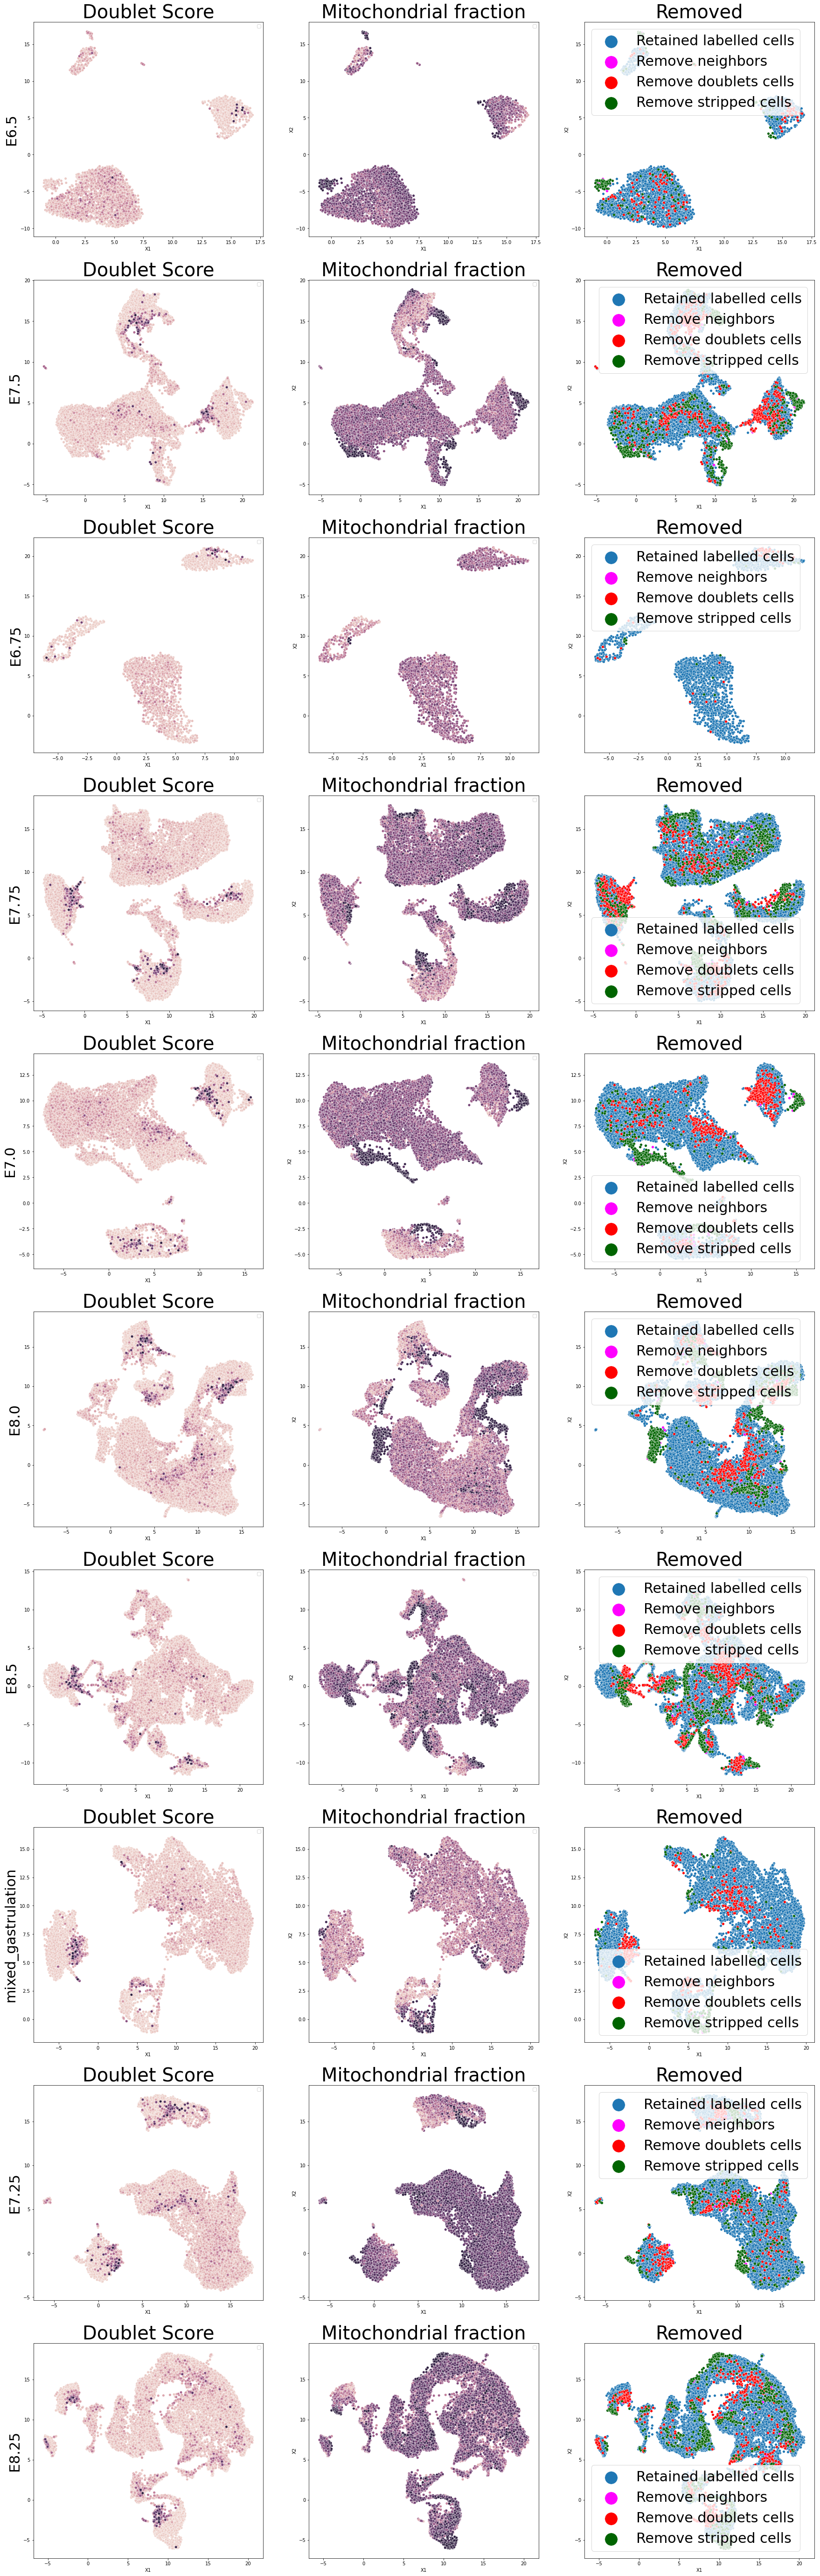

In [40]:
fig,ax= plt.subplots(len(a.obs["stage"].unique()),3,figsize=[30,10*len(a.obs["stage"].unique())])

for i,stage in enumerate(a.obs["stage"].unique()):
    
    bObs = a.obs.loc[a.obs["stage"]==stage,:]
    
    #Load auxiliar data
    data = pd.read_csv("./data/doublets/QC_doublet_UMAP_"+stage+".csv")

    #Make selection again for ploting purposes
    select_doublets = (bObs["nCounts"]>MAX_N_COUNTS) | (bObs["scrublet_doublet_score"]>DOUBLET_SCORE_MAX_THRESHOLD)
    select_doublets = select_doublets.values
    select_stripped = (bObs["mtFraction"]<MIN_MT_FRACTION)
    select_stripped = select_stripped.values
    aux_select_stripped = (bObs["mtFraction"]<MIN_MT_FRACTION) | (bObs["nCounts"]>MAX_N_COUNTS)
    aux_select_stripped = aux_select_stripped.values
    select_neighbors_imputed = bObs.loc[:,"neighbors_imputed"].values > .5
    
    # Plot removed cells
    order = np.argsort(bObs["scrublet_doublet_score"])
    hue = np.sort(bObs["scrublet_doublet_score"])
    sb.scatterplot("X1","X2",data=data.loc[order,:],hue=hue,s=30,ax=ax[i,0])
    ax[i,0].legend([])
    ax[i,0].set_title("Doublet Score",fontsize=40)

    sb.scatterplot("X1","X2",data=data,hue=-bObs["mtFraction"].values,s=30,ax=ax[i,1])
    ax[i,1].legend([])
    ax[i,1].set_title("Mitochondrial fraction",fontsize=40)

    sb.scatterplot("X1","X2",data=data,s=30,ax=ax[i,2])
    sb.scatterplot(data.loc[select_neighbors_imputed,"X1"],data.loc[select_neighbors_imputed,"X2"],color="magenta",s=30,ax=ax[i,2])
    sb.scatterplot(data.loc[select_doublets,"X1"],data.loc[select_doublets,"X2"],color="red",s=30,ax=ax[i,2])
    sb.scatterplot(data.loc[select_stripped,"X1"],data.loc[select_stripped,"X2"],color="darkgreen",s=30,ax=ax[i,2])
    ax[i,2].legend(["Retained labelled cells","Remove neighbors","Remove doublets cells","Remove stripped cells"],fontsize=30,markerscale=5)
    ax[i,2].set_title("Removed",fontsize=40)

    ax[i,0].set_ylabel(stage, fontsize=30)
    
    fig.savefig("./Plots/1_QC_umap.png",bbox_inches="tight",transparent=True)

In [41]:
a.obs.loc[:,"imputed"] = (a.obs.loc[:,"mtFraction"] < MIN_MT_FRACTION) + (a.obs.loc[:,"scrublet_doublet_score"] > DOUBLET_SCORE_MAX_THRESHOLD) + (a.obs.loc[:,"neighbors_imputed"] > .5) 

# Compare cells imputed by Pijuan-Sala and our analysis

In [42]:
d = pd.DataFrame(columns=["All","All_Ab","aB","stage","Pijuan","Us"])
for i,stage in enumerate(a.obs["stage"].unique()):
    b = a[a.obs["stage"]==stage]
    
    Ab = b[(b.obs.loc[:,"doublet"]+b.obs.loc[:,"stripped"])*np.invert(b.obs.loc[:,"imputed"])].shape[0]
    aB = b[np.invert(b.obs.loc[:,"doublet"]+b.obs.loc[:,"stripped"])*(b.obs.loc[:,"imputed"])].shape[0]
    AB = b[(b.obs.loc[:,"doublet"]+b.obs.loc[:,"stripped"])*(b.obs.loc[:,"imputed"])].shape[0]
    t = b.shape[0]
    
    p = ((b.obs.loc[:,"doublet"]+b.obs.loc[:,"stripped"])).sum()
    us = b.obs.loc[:,"imputed"].sum()
    
    d.loc[stage,:] = [(Ab+aB+AB)/t,(aB+AB)/t,aB/t,stage,p/t,us/t]

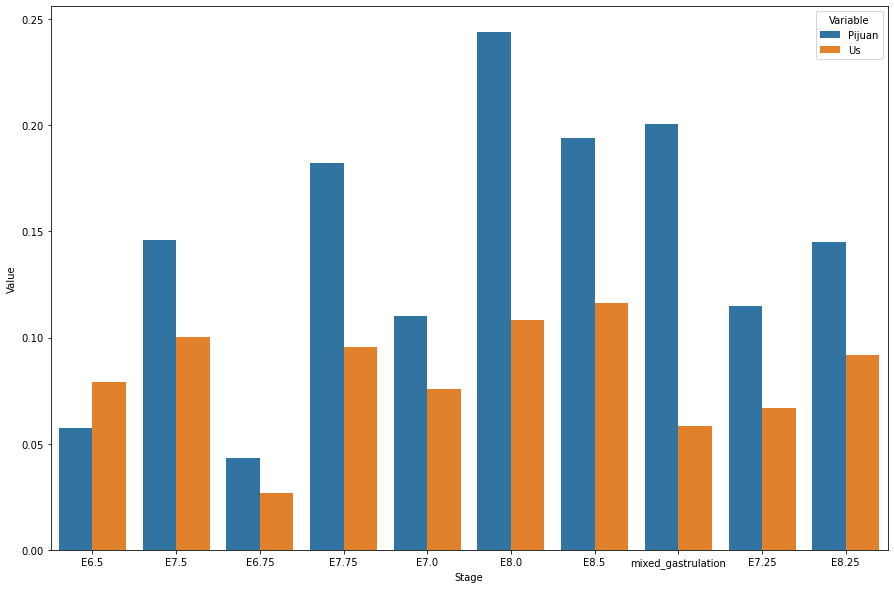

In [38]:
fig,ax = plt.subplots(1,1,figsize=[15,10])

m = d.iloc[:,-3:].melt(id_vars=["stage"]).rename(columns=str.title)

sb.barplot(x="Stage",y="Value",hue="Variable",data=m,ax=ax)

fig.show()

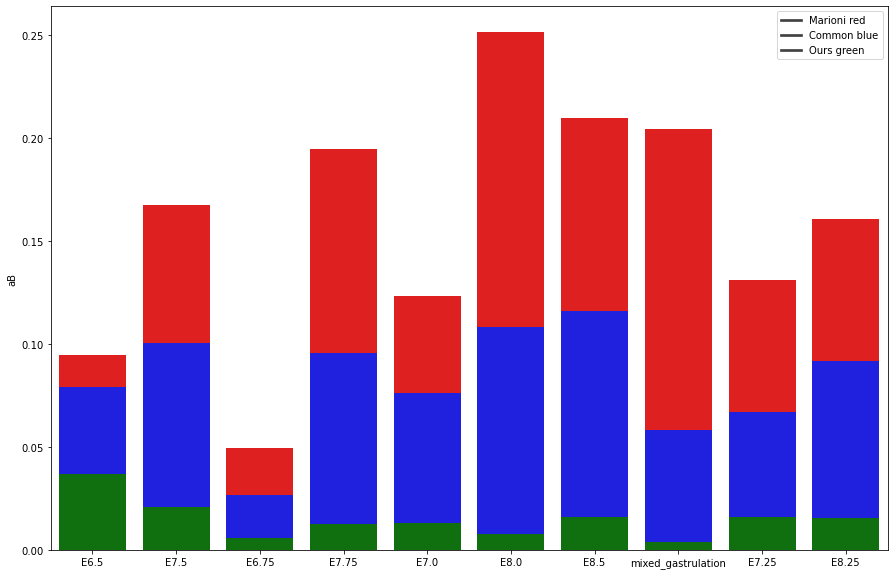

In [39]:
fig,ax = plt.subplots(1,1,figsize=[15,10])

sb.barplot(x=d.index,y="All",data=d,color="red",ax=ax)
sb.barplot(x=d.index,y="All_Ab",data=d,color="blue",ax=ax)
sb.barplot(x=d.index,y="aB",data=d,color="green",ax=ax)
ax.legend(["Marioni red","Common blue","Ours green"])

fig.show()

# Summary QC bounds

In summary, we set the following bounds to the dataset asquality control bounds. 

In [43]:
p = pd.DataFrame(index=["Lower Bound","Upper Bound"])
p["Counts"] = [MIN_COUNTS,MAX_COUNTS]
p["Number genes"] = [MIN_GENES,MAX_GENES]
p["Exp. genes per cell"] = [MIN_CELLS,MAX_CELLS]
p["mt fraction"] = [str(MIN_MT_FRACTION),MAX_MT_FRACTION]

p.to_csv("Tables/1_QC_Summary.csv")
p

Counts  Number genes  Exp. genes per cell mt fraction
Lower Bound  5.000000e+03  0.000000e+00         1.000000e+00      0.0022
Upper Bound  1.000000e+09  1.000000e+09         1.000000e+09           1

In [44]:
samp = np.sort(np.unique(a.obs["stage"].values))

p = pd.DataFrame(index=samp,columns=["Counts","Number Genes","mt Fraction","doublets","neighbors","Total","Removed %"])
p = p.astype({"Removed %":float})
for i in samp:
    b = a[a.obs["stage"]==i]
    p.loc[i,"Counts"] = b[(b.obs["nCounts"] < MIN_COUNTS) + (b.obs["nCounts"] > MAX_COUNTS)].shape[0]
    p.loc[i,"Number Genes"] = b[(b.obs["nGenes"] < MIN_GENES) + (b.obs["nGenes"] > MAX_GENES)].shape[0]
    p.loc[i,"mt Fraction"] = (b[(b.obs["mtFraction"] < MIN_MT_FRACTION)+(b.obs["mtFraction"] > MAX_MT_FRACTION)]).shape[0]
    p.loc[i,"doublets"] = (b[b.obs["scrublet_doublet_score"] > DOUBLET_SCORE_MAX_THRESHOLD]).shape[0]
    p.loc[i,"neighbors"] = (b[b.obs["neighbors_imputed"] > .5]).shape[0]
    p.loc[i,"Total"] = b.shape[0]
    p.loc[i,"Removed %"] = (p.loc[i,"Counts"]+p.loc[i,"Number Genes"]+p.loc[i,"mt Fraction"]+p.loc[i,"doublets"]+p.loc[i,"neighbors"])/b.shape[0]*100

p = p.round({"Removed %":1})
p.to_csv("Tables/1_QC_Summary_removed.csv")
p

Counts Number Genes mt Fraction doublets neighbors  Total  \
E6.5                    0            0         176      103       122   3697   
E6.75                   0            0          15       43         5   2169   
E7.0                    0            0         786      362       808  16571   
E7.25                   0            0         549      395       461  15294   
E7.5                    0            0         867      331       749  12876   
E7.75                   0            0        1131      452       931  17720   
E8.0                    0            0        1566      582      1698  22059   
E8.25                   0            0        1058      541       838  18642   
E8.5                    0            0        1755      504      1792  20978   
mixed_gastrulation      0            0         235      252       202   9325   

                    Removed %  
E6.5                     10.8  
E6.75                     2.9  
E7.0                     11.8  
E7.25                     9.2  
E7.5                     15.1  
E7.75                    14.2  
E8.0                     17.4  
E8.25                    13.1  
E8.5                     19.3  
mixed_gastrulation        7.4

# Remove cells and save

In [45]:
QC_cells_trimmed = (a.obs["nCounts"] < MIN_COUNTS) \
+ (a.obs["nCounts"] > MAX_COUNTS) \
+ (a.obs["nGenes"] < MIN_GENES) \
+ (a.obs["nGenes"] > MAX_GENES) \
+ (a.obs["mtFraction"] < MIN_MT_FRACTION) \
+ (a.obs["mtFraction"] > MAX_MT_FRACTION) \
+ (a.obs["scrublet_doublet_score"] > DOUBLET_SCORE_MAX_THRESHOLD)

QC_genes_trimmed = (a.var["nCells"] < MIN_CELLS)

a.obs.loc[:,"QC_basic_trimmed"] = QC_cells_trimmed
a.var.loc[:,"QC_basic_trimmed"] = QC_genes_trimmed

In [46]:
a = a[a.obs.loc[:,"QC_basic_trimmed"] == False,:]
a.obs.reset_index(drop=True,inplace=True)

In [47]:
#Save raw data
a.layers["counts"] = a.X.copy()

In [48]:
a.write("data/qc.h5ad");